<a href="https://colab.research.google.com/github/Zundock/Deep-whaling/blob/master/deep_learning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from googleapiclient.discovery import build
import io, os, cv2, csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)



!pip install kaggle


Download 100%.
    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 245kB 8.6MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/5a/2d/0c/9fc539e558586b9ed9127916a7f4e620163c24cc97460b1188
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [4]:
# if not os.path.exists('./data'):
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
if (not os.path.exists('./train')) and (not os.path.exists('./test')):
  !kaggle competitions download -c humpback-whale-identification
  !unzip -q train.zip -d train
  !unzip -q test.zip -d test
  !ls train | wc -l
  !ls test | wc -l
  


  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 74.1MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 93.1MB/s]
 99% 1.33G/1.35G [00:13<00:00, 113MB/s]
100% 1.35G/1.35G [00:13<00:00, 104MB/s]
100% 4.14G/4.16G [01:35<00:00, 36.4MB/s]
100% 4.16G/4.16G [01:35<00:00, 46.7MB/s]
25361
7960


In [0]:
# #!ls -a /root/.kaggle

# #!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
# if not os.path.exists('./train'):
#   !unzip -q train.zip -d train

# !ls train | wc -l

# if not os.path.exists('./test'):
#   !unzip -q test.zip -d test

# !ls test | wc -l

# Data preparation

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
w_2b069ba      48
w_d405854      47
w_f0fe284      45
w_789c969      45
w_778e474      40
w_343f088      40
w_5e8e218      40
w_60ce6fc      37
w_5a2634c      37
w_a9304b9      37
w_6822dbc      36
w_af367c3      35
w_f765256      34
w_1ca9ab1      34
w_17b0d3a      33
w_d72771c      32
w_08630fd      31
w_8c25681      31
w_6cda039      31
w_fd6a3ad      30
             ... 
w_6b00c91       1
w_2a7603f       1
w_d9e7ed3       1
w_c59d4b1       1
w_3f567ce       1
w_01e1b97       1
w_c7951e0       1
w_5c4c166       1
w_e8b2157       1
w_365b7ad       1
w_181ab06       1
w_5c4f274       1
w_2c0f96c       1
w_21666ad       1
w_3c58b68       1
w_29c0caf       1
w_e49ade7       1
w_9cc2050       1
w_ed5c855       1
w_81eb375       1
w_916c746       1
w_b0f07c7       1
w_5031cac       1
w_59f4653       1
w_19dfa67 

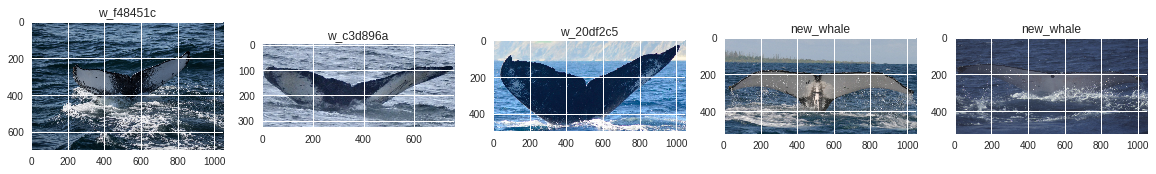

In [5]:
train_df = pd.read_csv("./train.csv")
img_path = './train/'

#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(train_df.Image[:5], train_df.Id[:5])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(imread(os.path.join(img_path,images[ii][0])))
    c_ax.set_title(images[ii][1])

#how many photos of each whail    
train_df.Id.value_counts()

In [6]:
# Make test directory

from distutils.dir_util import copy_tree

#create directories
if not os.path.exists('./test_folder'):
  os.mkdir('./test_folder')
  os.mkdir('./test_folder/test_images')

# copy subdirectory example
fromDirectory = img_path
toDirectory = "test_folder/test_images"

copy_tree(fromDirectory, toDirectory, verbose=1)

['test_folder/test_images/c5f877d7e.jpg',
 'test_folder/test_images/2f213724e.jpg',
 'test_folder/test_images/953422a9a.jpg',
 'test_folder/test_images/fdda3c3c2.jpg',
 'test_folder/test_images/bbafa3b94.jpg',
 'test_folder/test_images/6ac05e07f.jpg',
 'test_folder/test_images/b1dfad898.jpg',
 'test_folder/test_images/7a8853ce6.jpg',
 'test_folder/test_images/12a50bd2c.jpg',
 'test_folder/test_images/a8046cd00.jpg',
 'test_folder/test_images/bca69f23c.jpg',
 'test_folder/test_images/07cc1f3af.jpg',
 'test_folder/test_images/9102a74ab.jpg',
 'test_folder/test_images/892d5bb06.jpg',
 'test_folder/test_images/e7f6a5934.jpg',
 'test_folder/test_images/f9d0f3a66.jpg',
 'test_folder/test_images/3f390df31.jpg',
 'test_folder/test_images/b3a0b31fe.jpg',
 'test_folder/test_images/3da0f8292.jpg',
 'test_folder/test_images/06e958fef.jpg',
 'test_folder/test_images/b35c17b62.jpg',
 'test_folder/test_images/a7bb9db40.jpg',
 'test_folder/test_images/883616414.jpg',
 'test_folder/test_images/d9fd69da

In [8]:
#Image size
sz = 100

# create generators
datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.1)
test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df, directory=img_path, 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(sz,sz), batch_size=32, subset = "training")

validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=img_path, 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(sz,sz), batch_size=32, subset = "validation")

test_generator = test_datagen.flow_from_directory(directory="test_folder", 
    seed = 42, class_mode=None, target_size=(sz,sz), batch_size=1, shuffle = False)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 22825 images belonging to 5005 classes.
Found 2536 images belonging to 5005 classes.
Found 25361 images belonging to 1 classes.


In [9]:
#Training metrices
from keras.metrics import top_k_categorical_accuracy

''' the function top_5_accuracy is from Peter's kernel:
    https://www.kaggle.com/pestipeti/keras-cnn-starter
'''
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

#Create the model
  
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (100, 100, 3)))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling2D()) 
# model.add(Flatten())
model.add(Dense(5005, activation = 'softmax'))
# model.summary()

model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)


# Train the model
history= model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2, callbacks = [checkpointer, early_stopping])

Epoch 1/2
713/713 [==============================] - 296s 415ms/step - loss: 6.1991 - acc: 0.3765 - top_5_accuracy: 0.3853 - val_loss: 6.8076 - val_acc: 0.3908 - val_top_5_accuracy: 0.3995

Epoch 00001: val_loss improved from inf to 6.80759, saving model to weights.hdf5
Epoch 2/2
713/713 [==============================] - 265s 372ms/step - loss: 5.7068 - acc: 0.3798 - top_5_accuracy: 0.3885 - val_loss: 6.7648 - val_acc: 0.3950 - val_top_5_accuracy: 0.4046

Epoch 00002: val_loss improved from 6.80759 to 6.76481, saving model to weights.hdf5


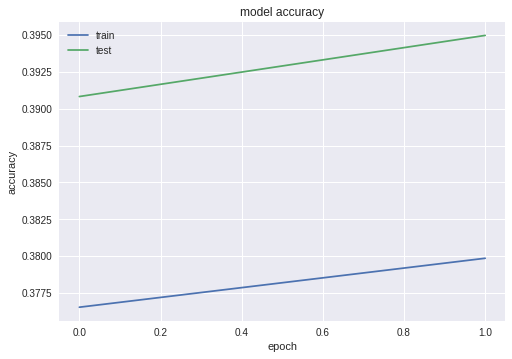

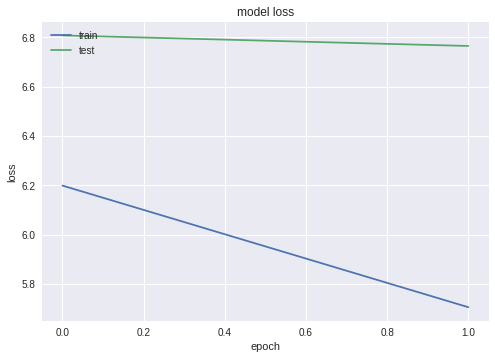

In [10]:
#plot history

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [11]:
#we need to use .reset() here otherwise
#the other of predictions will be different
#then the expected
test_generator.reset()
pred = model.predict_generator(test_generator,verbose = 1,steps=7960)

7960/7960 [==============================] - 120s 15ms/step


In [28]:
'''This filters only the top 5 possible ids of an image'''
pred_sorted = np.argsort(-pred, axis = 1)[:,:5]
pred_sorted

array([[  3, 265, 166,  18,  58],
       [  3, 265, 166,  18,  58],
       [  3, 265, 166,  18, 169],
       ...,
       [  3, 265, 166,  18,  58],
       [  3, 265, 166,  18, 169],
       [  3, 265, 166,  18,  58]])

In [0]:
'''
Now we generate a map of each 
index to an Id on the format 
{
0: 'w_f48451c',
1: 'w_c3d896a',
2: 'w_20df2c5',
...
}
'''
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [30]:
'''
Here we prepare pred_ids, which is a list of lists containing 
the top 5 ids by name. For example, w_13ae3d4. 
'''
from tqdm import tqdm
#create empty list
pred_ids = list()
for i,row in enumerate(tqdm(pred_sorted)):
    #create a temporary list to store the ids for a given image
    temp_list = []
    for j,value in enumerate(row):
        #for each index in pred_sorted, append the real Id in temp_list
        temp_list.append(labels[row[j]])
    #append all 5 ids for a given image to pred_ids
    #effectively creating a similar list to pred_sorted
    #but with the real ids
    pred_ids.append(temp_list)

100%|██████████| 7960/7960 [00:00<00:00, 153463.78it/s]


In [0]:
'''create the final predictions by using all ids in a single string'''
final_preds = []
for i,top_5_ids in enumerate(pred_ids):
    final_preds.append(' '.join(pred_ids[i]))

In [0]:
'''delete the files on disk - otherwise the Kaggle kernel will throw an error'''
import shutil
shutil.rmtree('test_folder', ignore_errors=True)

In [40]:
submission = pd.DataFrame({"Image": os.listdir('./test'), "Id": final_preds})
submission = submission[['Image','Id']]
submission.to_csv("submission.csv", index = False, columns=['Image', 'Id'])
submission.head()



,Image,Id
0,48edcb488.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
1,afcc2fd2b.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
2,4021abe4d.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_d405854
3,246a3b660.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
4,2f53e8505.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
